In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# Simulated Preference Dataset Generator
- original code
- subgroups

In [107]:
########### hyperparameters for the dataset ################
feature_dim = 20
metric_rank = 1
num_items = 100
num_users = 10
num_pairs_per_user = 300
noise_type = 'logistic'
noise_beta = 1
# noise_type = 'none'
# noise_beta = 0
num_groups = 3

In [96]:
import scipy.stats as st
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio
import utils


'''
Desc: Generates normally distributed data along with ground-truth metric and user points (Refer to the original code)

Inputs:
    feature_dim: feature dimensions
    metric_rank: metric rank
    num_items: number of items
    num_users: number of users
    num_pairs_per_user: number of measurements per user
    noise type: type of noise in measurement model, from {'none', 'logistic'}
    noise_beta: noise level
    num_groups: number of subgroups
'''

assert metric_rank <= feature_dim, 'metric rank must be equal to or smaller then feature dim'

# generate ground-truth metric
if metric_rank < feature_dim:
    # low-dimensional orthogonal matrix
    L = st.ortho_group.rvs(dim=feature_dim)
    L = L[:,:metric_rank]
    M = (feature_dim / np.sqrt(metric_rank)) * L @ L.T  # keep the frob_norm = feature_dim
elif metric_rank == feature_dim:
    # arbitrary PSD metric, normalized to have Frobenius norm of d
    L = np.random.multivariate_normal(np.zeros(feature_dim), np.eye(feature_dim), feature_dim)
    M = L @ L.T
    M = M * (feature_dim / np.linalg.norm(M, 'fro'))

# generate user points (methods depend on the size of the num_groups)
if num_groups == 1:
    # original code
    U = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_users).T
    # pseudo user points
    V = -2*M @ U
    # generate items and comparisons
    Xdata = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_items).T
    S = list(zip(list(np.repeat(list(range(num_users)), num_pairs_per_user)),
                       [tuple(np.random.choice(num_items, 2, replace=False)) for _ in range(num_pairs_per_user*num_users)]))
    Y, Y_noiseless, Y_unquant = utils.one_bit_pairs(Xdata, S, M, V, noise_type, noise_beta)
elif num_groups > 1:
    # only need to create several ideal points (num_groups)
    U_subgroups = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_groups).T
    # Then we need to simulate different users, each user's point is a weight-average of the ideal points
    alpha = np.random.rand(num_users, num_groups)
    alpha = alpha / alpha.sum(axis=1).reshape(-1,1)
    U = U_subgroups @ alpha.T
    # pseudo user points
    V = -2*M @ U
    # generate items and comparisons
    Xdata = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_items).T
    S = list(zip(list(np.repeat(list(range(num_users)), num_pairs_per_user)),
                       [tuple(np.random.choice(num_items, 2, replace=False)) for _ in range(num_pairs_per_user*num_users)]))
    Y, Y_noiseless, Y_unquant = utils.one_bit_pairs(Xdata, S, M, V, noise_type, noise_beta)





# group_dataset test

In [2]:
from group_dataset import Dataset
from metric_check import train_main

########### hyperparameters for the dataset ################
feature_dim = 10
metric_rank = 1
num_items = 100
num_users = 10
num_pairs_per_user = 1000
noise_type = 'logistic'
noise_beta = 1
num_groups = 3

In [3]:
normal_dataset = Dataset(dataset_type='Normal',
                         d=feature_dim,
                         r=metric_rank,
                         n=num_items,
                         N=num_users,
                         m=num_pairs_per_user,
                         noise_type=noise_type,
                         noise_beta=noise_beta,
                         num_groups=num_groups)

In [4]:
########### initialize the dataloders ################
normal_data = normal_dataset.getAllData()
items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
true_y_noiseless = normal_dataset.Y_noiseless

In [5]:
args = {
        'feature_dim': 10,
        'metric_rank': 1,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 300,
}

train_stats, learner = train_main(args, normal_dataset, relative_error_ind=False)

100%|██████████| 2000/2000 [01:32<00:00, 21.51it/s, test_accu=0.804]


In [3]:
from group_dataset import Dataset
from metric_check import train_main
from tqdm import tqdm

res_list = []

for i in tqdm(range(1,10)):
    ########### hyperparameters for the dataset ################
    feature_dim = 10
    metric_rank = 10
    num_items = 100
    num_users = 100
    num_pairs_per_user = 1000
    noise_type = 'logistic'
    noise_beta = 1
    num_groups = i

    normal_dataset = Dataset(dataset_type='Normal',
                            d=feature_dim,
                            r=metric_rank,
                            n=num_items,
                            N=num_users,
                            m=num_pairs_per_user,
                            noise_type=noise_type,
                            noise_beta=noise_beta,
                            num_groups=num_groups)

    ########### initialize the dataloders ################
    normal_data = normal_dataset.getAllData()
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    true_y_noiseless = normal_dataset.Y_noiseless

    args = {
            'feature_dim': feature_dim,
            'metric_rank': metric_rank,
            'num_items': num_items,
            'num_users': num_users,
            'num_pairs_per_user': 300,
    }

    train_stats, learner = train_main(args, normal_dataset, relative_error_ind=False)

    res_list.append((train_stats, learner))

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [16:05<2:08:42, 965.34s/it]

In [ ]:
torch.save(res_list,'subgroups_res_list.pt')

In [2]:
res_list = torch.load('subgroups_res_list.pt')

In [6]:
num_subgroups_list = list(range(1,11))
test_accu_list = []
for res in res_list:
    test_accu_list.append(res[0]['test_accu_record'][-1])

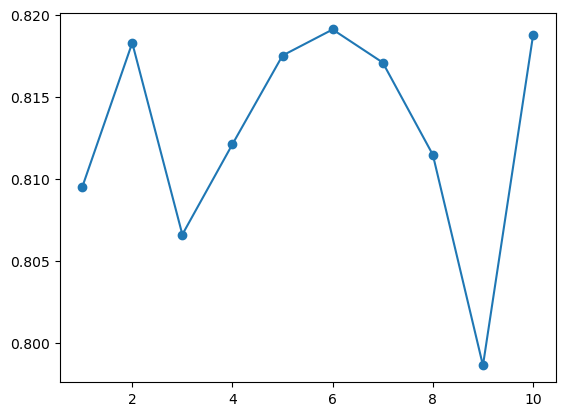

In [8]:
import matplotlib.pyplot as plt
plt.plot(num_subgroups_list,test_accu_list,'-o')

# subgroups analysis

In [87]:
import os
import torch
from tqdm import tqdm
fileNames = os.listdir('./save_subgroups/')
filePaths = [os.path.join('./save_subgroups/',i) for i in fileNames]

In [88]:
res_list = [torch.load(filePath) for filePath in tqdm(filePaths)]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:12<00:00, 25.26s/it]


In [91]:
sample_size = []
final_test_accu = []
final_relative_metric_error = []
final_relative_ideal_point_error = []
final_learner = []
for i in res_list:
    sample_size.append(i['args']['num_pairs_per_user'])
    final_test_accu.append(i['train_stats']['test_accu_record'][-1])
    final_learner.append(i['learner'])

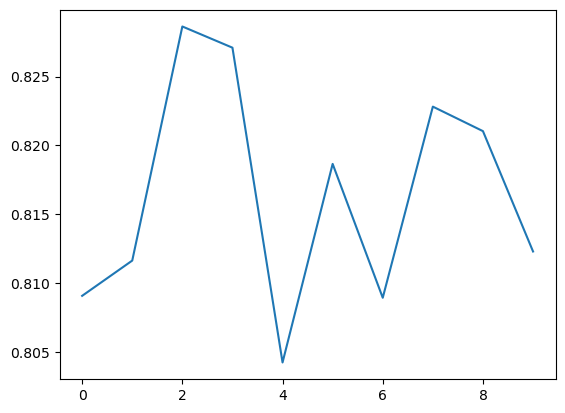

In [93]:
plt.plot(final_test_accu)

# MetricPreferenceLearner (subgroups version)

In [113]:
# original version

import torch
import torch.nn as nn
import torch.nn.functional as F

class MetricPrefLearner(nn.Module):
    
    def __init__(self, dim_feature, num_users, items):
        '''
        items shape: np.array (dim_feature, num_items)
        '''
        super().__init__()
        self.dim_feature = dim_feature
        self.num_users = num_users
        self.items = items
        self.us = nn.Parameter(torch.randn((self.dim_feature, self.num_users)))

    def assignModel(self, init_model):
        '''
        Use whatever model you like
        One Condition must be satisfied: input_dim == output_dim == dim_feature
        '''
        self.model = init_model

    def forward(self, x):
        '''
        x shape: (user_id, (item_i, item_j))
        '''
        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        x_is, x_js = torch.Tensor(self.items[:,x_is]), torch.Tensor(self.items[:,x_js])
        us_k_track =self.us[:,user_ids]
        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        ele_1 = self.model(x_is_minus_us)
        ele_2 = self.model(x_js_minus_us)
        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        return delta

In [114]:
# updated version: use subgroups + softmax weights

import torch
import torch.nn as nn
import torch.nn.functional as F

class MetricPrefLearner_groups(nn.Module):
    
    def __init__(self, dim_feature, num_users, items, num_groups=None):
        '''
        items shape: np.array (dim_feature, num_items)
        '''
        super().__init__()
        self.dim_feature = dim_feature
        self.num_users = num_users
        self.items = items
        self.num_groups = num_groups
        assert num_groups != 1, 'number of groups should larger than 1'

        # two different modeling methods (depend on the num_groups)
        if self.num_groups == None:
            self.us = nn.Parameter(torch.randn((self.dim_feature, self.num_users)))
        elif self.num_groups > 1:
            self.us_groups = nn.Parameter(torch.randn((self.dim_feature, self.num_groups)))
            self.unconstrained_weights = nn.Parameter(torch.randn((self.num_groups, self.num_users)))   # this is unconstrained weights, need to use softmax function to normalize it into probabilities
            self.softmax = nn.Softmax(dim=0)    # alongside the num_groups dimension

    def assignModel(self, init_model):
        '''
        Use whatever model you like
        One Condition must be satisfied: input_dim == output_dim == dim_feature
        '''
        self.model = init_model

    def forward(self, x):
        '''
        x shape: (user_id, (item_i, item_j))
        '''

        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        x_is, x_js = torch.Tensor(self.items[:,x_is]), torch.Tensor(self.items[:,x_js])
        if self.num_groups == None:
            us_k_track =self.us[:,user_ids]
        else:
            us_probs = self.softmax(self.unconstrained_weights[:,user_ids])
            us_k_track = self.us_groups @ us_probs
        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        ele_1 = self.model(x_is_minus_us)
        ele_2 = self.model(x_js_minus_us)
        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        return delta

In [115]:

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    
    probabilities = logistic(targets * predictions)
    # print(probabilities)
    nll = -torch.sum(torch.log(probabilities))
    # print(nll)
    return nll

In [116]:
# run some test code

from group_dataset import Dataset
from torch.utils.data import DataLoader


########### hyperparameters for the dataset ################
feature_dim = 10
metric_rank = 10
num_items = 100
num_users = 100
num_pairs_per_user = 1000
noise_type = 'logistic'
noise_beta = 1
num_groups = 5

normal_dataset = Dataset(dataset_type='Normal',
                            d=feature_dim,
                            r=metric_rank,
                            n=num_items,
                            N=num_users,
                            m=num_pairs_per_user,
                            noise_type=noise_type,
                            noise_beta=noise_beta,
                            num_groups=num_groups)


In [117]:
########### hyperparameters for the training ################
# Notice: these hyperparameters are chosen by the grid_search experiments
epochs = 2000
samples_per_user = 500
bs = 64
lr = 0.005
weight_decay_us = 0
weight_decay_net = 0.001
optimizer_name = 'adam'

In [118]:


########### initialize the dataloders ################
normal_data = normal_dataset.getAllData()
items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
true_y_noiseless = normal_dataset.Y_noiseless
obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*samples_per_user)

############ define dataloader ################
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [127]:
train_stats = {
    'train_loss_per_batch_record': [],
    'train_accu_record': [],
    'test_loss_per_batch_record': [],
    'test_accu_record': [],
    'relative_metric_error_record': [],
    'relative_ideal_point_error_record': [],
}


############ initialize the model and the learner################
from mlp import projector
net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
# learner_v2 = MetricPrefLearner_v2(dim_feature=feature_dim, num_users=num_users, items=items, num_groups=5)
learner = MetricPrefLearner_groups(dim_feature=feature_dim, num_users=num_users, items=items, num_groups=2)
learner.assignModel(net)

us_params = []
net_params = []
for name, param in learner.named_parameters():
    if 'us' in name:
        us_params.append(param)
    elif 'model' in name:
        net_params.append(param)

############ define loss and optimizer ################
weight_decay_dic = [
    {'params': us_params, 'weight_decay': weight_decay_us},
    {'params': net_params, 'weight_decay': weight_decay_net}
]
loss_fn = hinge_loss
optimizer = torch.optim.Adam(weight_decay_dic, lr=lr, betas=(0.9, 0.999), eps=1e-8)

for x,y in train_dataloader:
    optimizer.zero_grad()
    pred_delta = learner(x)
    acc_batch = torch.sum((pred_delta * y)>0)
    loss = loss_fn(pred_delta,y)
    train_stats['train_loss_per_batch_record'].append(loss.item())
    train_stats['train_accu_record'].append(acc_batch/len(y))
    loss.backward()
    optimizer.step()

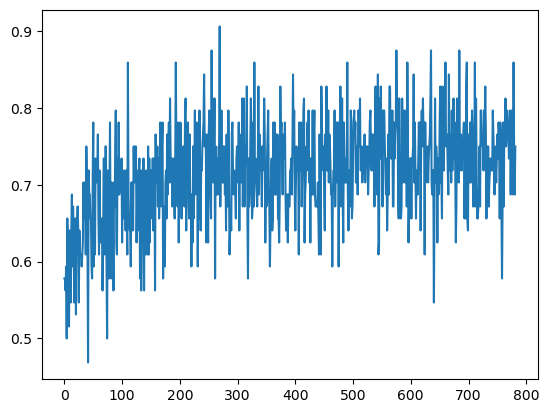

In [128]:
plt.plot(train_stats['train_accu_record'])

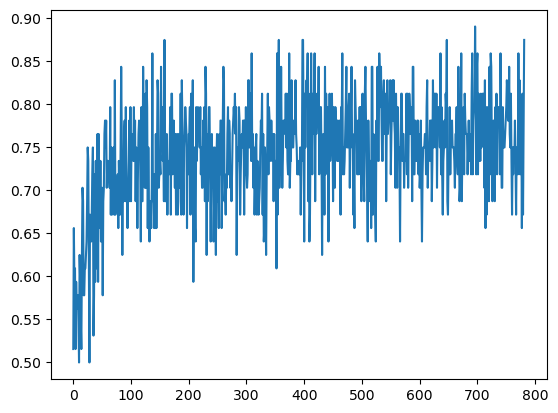

In [126]:
plt.plot(train_stats['train_accu_record'])

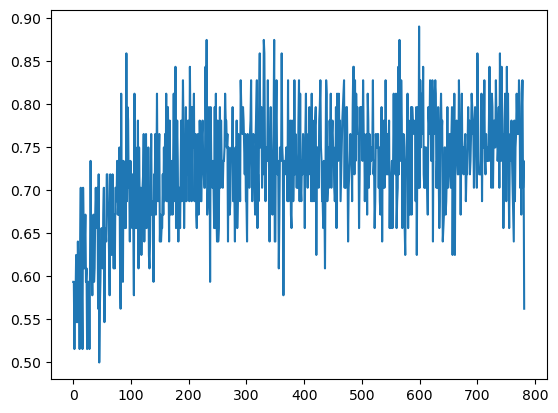

In [124]:
plt.plot(train_stats['train_accu_record'])

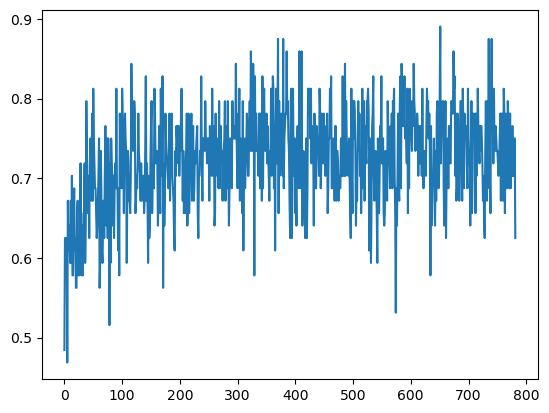

In [122]:
plt.plot(train_stats['train_accu_record'])

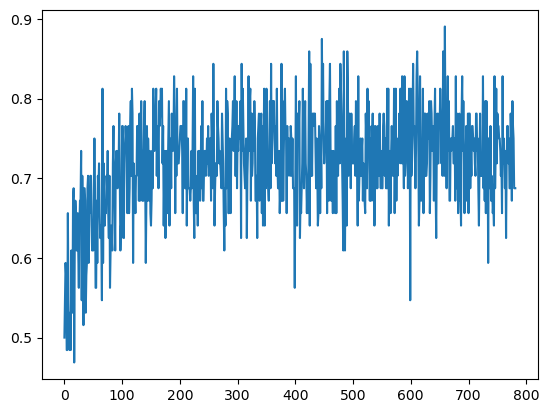

In [120]:
plt.plot(train_stats['train_accu_record'])

In [107]:
us_params = []
net_params = []
unconstrained_weights_params = []
for name, param in learner.named_parameters():
    if 'us' in name:
        us_params.append(param)
    elif 'model' in name:
        net_params.append(param)
    elif 'unconstrained_weights' in name:
        unconstrained_weights_params.append(param)

# subgroups total test

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import group
import torch
from torch.utils.data import DataLoader, Dataset

# system related packages
from copy import deepcopy
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import re
import itertools

# customized packages
import group_dataset
import dataset
import utils
from mlp import projector
from metricpref_learner import MetricPrefLearner, MetricPrefLearner_groups

def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs,relative_error_ind=True, groups=False, true_M=None, true_u=None, true_alpha=None):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
        'relative_weights_error_record': [],
    }
    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            optimizer.zero_grad()
            pred_delta = learner(x)
            ############################ Evaluation part start #############################
            acc_batch = torch.sum((pred_delta * y)>0)
            if relative_error_ind:
                # calculate the relative_metric_error
                L = learner.model.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                if groups:
                    alpha = learner.softmax(learner.unconstrained_weights).T
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us_groups) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
                    relative_weights_error_record = (torch.norm(torch.tensor(true_alpha)-alpha) / torch.norm(torch.tensor(true_alpha))).item()
                    train_stats['relative_weights_error_record'].append(relative_weights_error_record)
                else:
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            ############################ Evaluation part end #############################   
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/len(y))
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)
            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples
    return val_stat

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    probabilities = logistic(targets * predictions)
    nll = -torch.sum(torch.log(probabilities))
    return nll

# in order to keep using the same dataset
# we only initialize the dataset for one time
def get_dataset(args):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    num_pairs_per_user = args['num_pairs_per_user']
    noise_type = args['noise_type']
    noise_beta = args['noise_beta']
    num_groups = args['num_groups']
    normal_dataset = group_dataset.Dataset(dataset_type='Normal', d=feature_dim, 
                                            r=metric_rank, n=num_items, 
                                            N=num_users, m=num_pairs_per_user, 
                                            noise_type=noise_type, 
                                            noise_param=noise_beta, X=None,
                                            num_groups=num_groups)
    return normal_dataset

def train_main(args, normal_dataset, relative_error_ind=True):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    samples_per_user = args['samples_per_user']
    num_groups = args['num_groups']
    ########### hyperparameters for the training ################
    # Notice: these hyperparameters are chosen by the grid_search experiments
    epochs = args['epochs'] #2000
    bs = args['bs']#64
    lr = args['lr']#0.005  # TODO: use different learning rate for us and net
    weight_decay_us = args['weight_decay_us']#0
    weight_decay_net = args['weight_decay_net']#0.001
    weight_decay_unconstrained_weight = args['weight_decay_unconstrained_weight']#0
    optimizer_name = args['optimizer_name']#'adam'
    ########### initialize the dataloders ################
    normal_data = normal_dataset.getAllData()
    if num_groups:
        true_U_subgroups = normal_dataset.U_subgroups
        true_alpha = normal_dataset.alpha
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*samples_per_user)
    ############ define dataloader ################
    train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    ############ initialize the model and the learner################
    net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
    learner = MetricPrefLearner_groups(dim_feature=feature_dim, num_users=num_users, items=items, num_groups=num_groups)
    learner.assignModel(net)
    us_params = []
    net_params = []
    unconstrained_weights_params = []
    for name, param in learner.named_parameters():
        if 'us' in name:
            us_params.append(param)
        elif 'model' in name:
            net_params.append(param)
        elif 'unconstrained_weights' in name:
            unconstrained_weights_params.append(param)
    ############ define loss and optimizer ################
    weight_decay_dic = [
        {'params': us_params, 'weight_decay': weight_decay_us},
        {'params': net_params, 'weight_decay': weight_decay_net},
        {'params': unconstrained_weights_params, 'weight_decay': weight_decay_unconstrained_weight},
    ]
    loss_fn = hinge_loss
    if optimizer_name == 'adam':
            optimizer = torch.optim.Adam(weight_decay_dic, lr=lr, betas=(0.9, 0.999), eps=1e-8)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(weight_decay_dic, lr=lr, momentum=0.9)

    # important modification: record the metric error
    if num_groups:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_U_subgroups,groups=True,true_alpha=true_alpha)
    else:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_u)

    return train_stats, learner

def oracle_pred(normal_dataset):
    # Oracle prediction (just for verification) original version
    normal_data = normal_dataset.getAllData()

    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']

    delta_s = []
    pred_ys = []
    for obs in observations:
        user_id, comparison_pair = obs
        x_i, x_j = comparison_pair
        delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
        delta_s.append(delta)
        if delta > 0:
            pred_y = 1
        else:
            pred_y = -1
        pred_ys.append(pred_y)
    print('Oracle prediciton:', np.mean(pred_ys == true_y))
    return np.mean(pred_ys == true_y)




In [65]:
args = {
    'feature_dim': 10,
    'metric_rank': 10,
    'num_items': 100,
    'num_users': 50,
    'num_pairs_per_user': 500,
    'samples_per_user': 300,
    'noise_type': 'logistic',
    'noise_beta': 3,
    'num_groups': 8,
    'epochs': 2000,
    'bs': 64,
    'lr': 0.005,
    'weight_decay_us': 0,
    'weight_decay_net': 0.001,
    'weight_decay_unconstrained_weight': 0,
    'optimizer_name': 'adam',
}
normal_dataset = get_dataset(args)
oracle_pred(normal_dataset)

Oracle prediciton: 0.90816


0.90816

In [72]:
args = {
    'feature_dim': 10,
    'metric_rank': 10,
    'num_items': 100,
    'num_users': 50,
    'num_pairs_per_user': 500,
    'samples_per_user': 300,
    'noise_type': 'logistic',
    'noise_beta': 3,
    'num_groups': 8,
    'epochs': 100,
    'bs': 64,
    'lr': 0.005,
    'weight_decay_us': 0,
    'weight_decay_net': 0.001,
    'weight_decay_unconstrained_weight': 0,
    'optimizer_name': 'adam',
}

train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:40<00:00,  2.49it/s, test_accu=0.877]


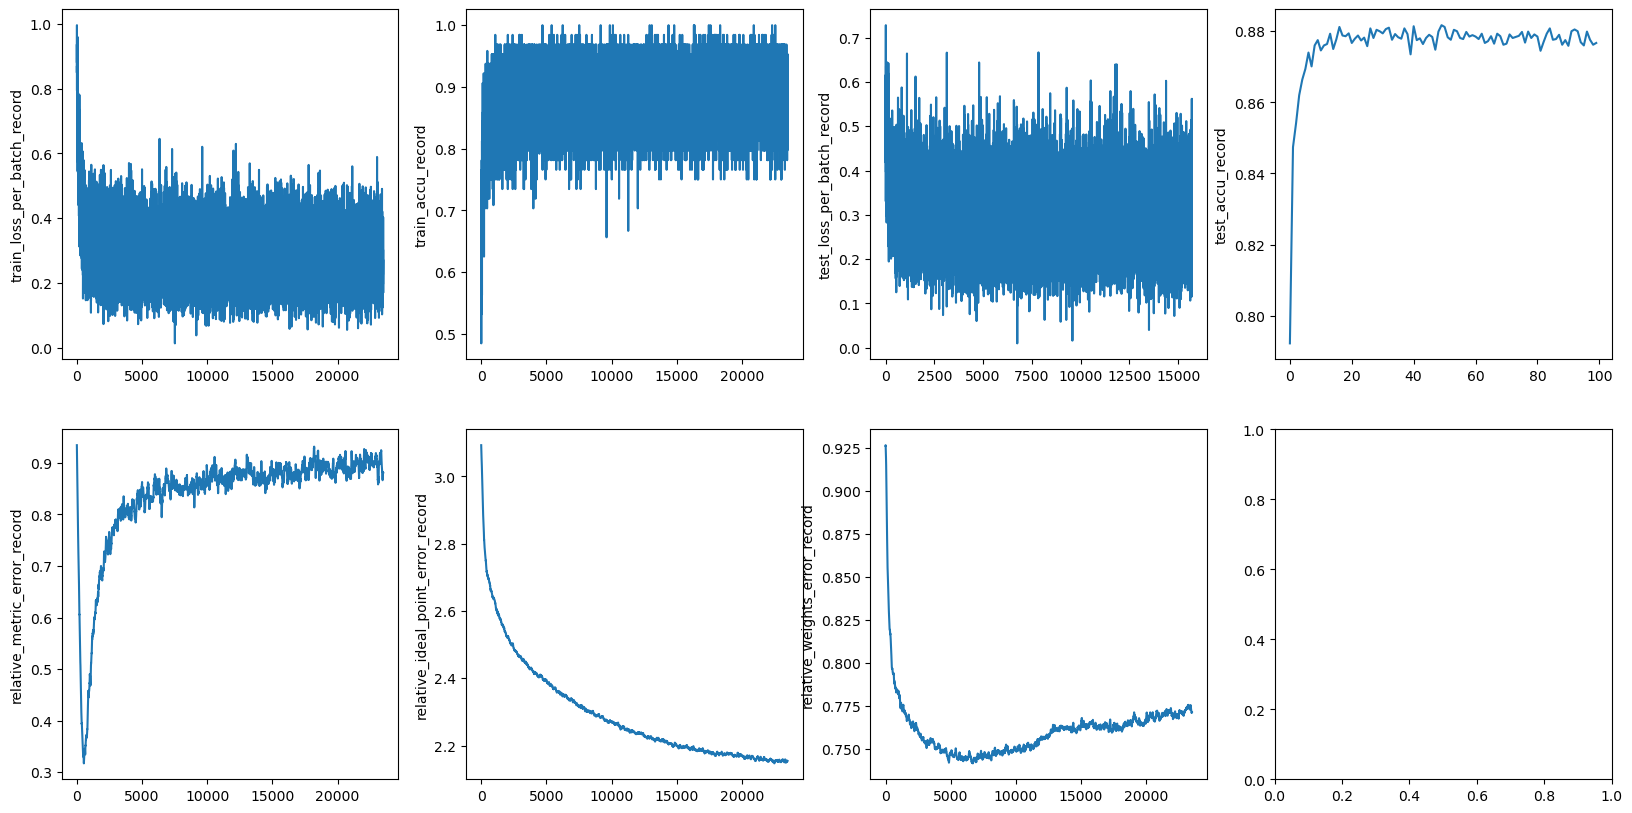

In [73]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

# forbid the weight update

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import group
import torch
from torch.utils.data import DataLoader, Dataset

# system related packages
from copy import deepcopy
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import re
import itertools

# customized packages
import group_dataset
import dataset
import utils
from mlp import projector
from metricpref_learner import MetricPrefLearner, MetricPrefLearner_groups

def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs,relative_error_ind=True, groups=False, true_M=None, true_u=None, true_alpha=None):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
        'relative_weights_error_record': [],
    }
    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            optimizer.zero_grad()
            pred_delta = learner(x)
            ############################ Evaluation part start #############################
            acc_batch = torch.sum((pred_delta * y)>0)
            if relative_error_ind:
                # calculate the relative_metric_error
                L = learner.model.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                if groups:
                    alpha = learner.softmax(learner.unconstrained_weights).T
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us_groups) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
                    relative_weights_error_record = (torch.norm(torch.tensor(true_alpha)-alpha) / torch.norm(torch.tensor(true_alpha))).item()
                    train_stats['relative_weights_error_record'].append(relative_weights_error_record)
                else:
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            ############################ Evaluation part end #############################   
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/len(y))
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)
            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples
    return val_stat

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    probabilities = logistic(targets * predictions)
    nll = -torch.sum(torch.log(probabilities))
    return nll

# in order to keep using the same dataset
# we only initialize the dataset for one time
def get_dataset(args):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    num_pairs_per_user = args['num_pairs_per_user']
    noise_type = args['noise_type']
    noise_beta = args['noise_beta']
    num_groups = args['num_groups']
    normal_dataset = group_dataset.Dataset(dataset_type='Normal', d=feature_dim, 
                                            r=metric_rank, n=num_items, 
                                            N=num_users, m=num_pairs_per_user, 
                                            noise_type=noise_type, 
                                            noise_param=noise_beta, X=None,
                                            num_groups=num_groups)
    return normal_dataset

def train_main(args, normal_dataset, relative_error_ind=True):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    samples_per_user = args['samples_per_user']
    num_groups = args['num_groups']
    ########### hyperparameters for the training ################
    # Notice: these hyperparameters are chosen by the grid_search experiments
    epochs = args['epochs'] #2000
    bs = args['bs']#64
    lr = args['lr']#0.005  # TODO: use different learning rate for us and net
    weight_decay_us = args['weight_decay_us']#0
    weight_decay_net = args['weight_decay_net']#0.001
    weight_decay_unconstrained_weight = args['weight_decay_unconstrained_weight']#0
    optimizer_name = args['optimizer_name']#'adam'
    ########### initialize the dataloders ################
    normal_data = normal_dataset.getAllData()
    if num_groups:
        true_U_subgroups = normal_dataset.U_subgroups
        true_alpha = normal_dataset.alpha
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*samples_per_user)
    ############ define dataloader ################
    train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    ############ initialize the model and the learner################
    net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
    learner = MetricPrefLearner_groups(dim_feature=feature_dim, num_users=num_users, items=items, num_groups=num_groups)
    learner.assignModel(net)
    us_params = []
    net_params = []
    unconstrained_weights_params = []
    for name, param in learner.named_parameters():
        if 'us' in name:
            us_params.append(param)
        elif 'model' in name:
            net_params.append(param)
        # elif 'unconstrained_weights' in name:
        #     unconstrained_weights_params.append(param)
    ############ define loss and optimizer ################
    weight_decay_dic = [
        {'params': us_params, 'weight_decay': weight_decay_us},
        {'params': net_params, 'weight_decay': weight_decay_net},
        # {'params': unconstrained_weights_params, 'weight_decay': weight_decay_unconstrained_weight},
    ]
    loss_fn = hinge_loss
    if optimizer_name == 'adam':
            optimizer = torch.optim.Adam(weight_decay_dic, lr=lr, betas=(0.9, 0.999), eps=1e-8)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(weight_decay_dic, lr=lr, momentum=0.9)

    # important modification: record the metric error
    if num_groups:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_U_subgroups,groups=True,true_alpha=true_alpha)
    else:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_u)

    return train_stats, learner

def oracle_pred(normal_dataset):
    # Oracle prediction (just for verification) original version
    normal_data = normal_dataset.getAllData()

    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']

    delta_s = []
    pred_ys = []
    for obs in observations:
        user_id, comparison_pair = obs
        x_i, x_j = comparison_pair
        delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
        delta_s.append(delta)
        if delta > 0:
            pred_y = 1
        else:
            pred_y = -1
        pred_ys.append(pred_y)
    print('Oracle prediciton:', np.mean(pred_ys == true_y))
    return np.mean(pred_ys == true_y)




In [68]:
args = {
    'feature_dim': 10,
    'metric_rank': 10,
    'num_items': 100,
    'num_users': 50,
    'num_pairs_per_user': 500,
    'samples_per_user': 300,
    'noise_type': 'logistic',
    'noise_beta': 3,
    'num_groups': 8,
    'epochs': 100,
    'bs': 64,
    'lr': 0.005,
    'weight_decay_us': 0,
    'weight_decay_net': 0.001,
    'weight_decay_unconstrained_weight': 0,
    'optimizer_name': 'adam',
}
normal_dataset = get_dataset(args)
oracle_pred(normal_dataset)

Oracle prediciton: 0.88676


0.88676

In [69]:
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:38<00:00,  2.62it/s, test_accu=0.855]


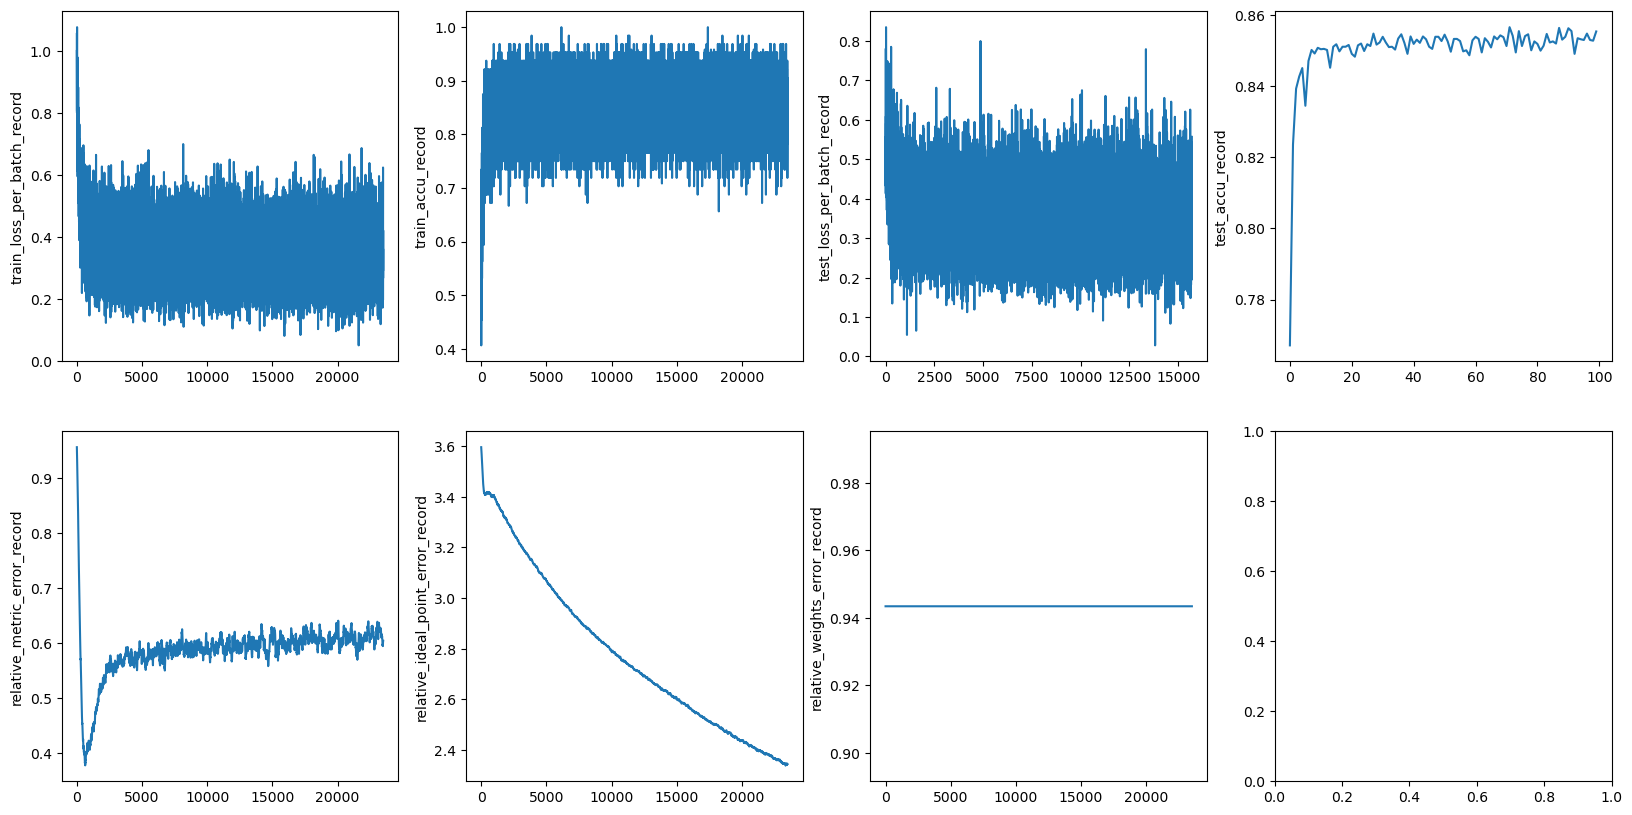

In [70]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

In [28]:
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

100%|██████████| 2000/2000 [01:41<00:00, 19.78it/s, test_accu=0.738]


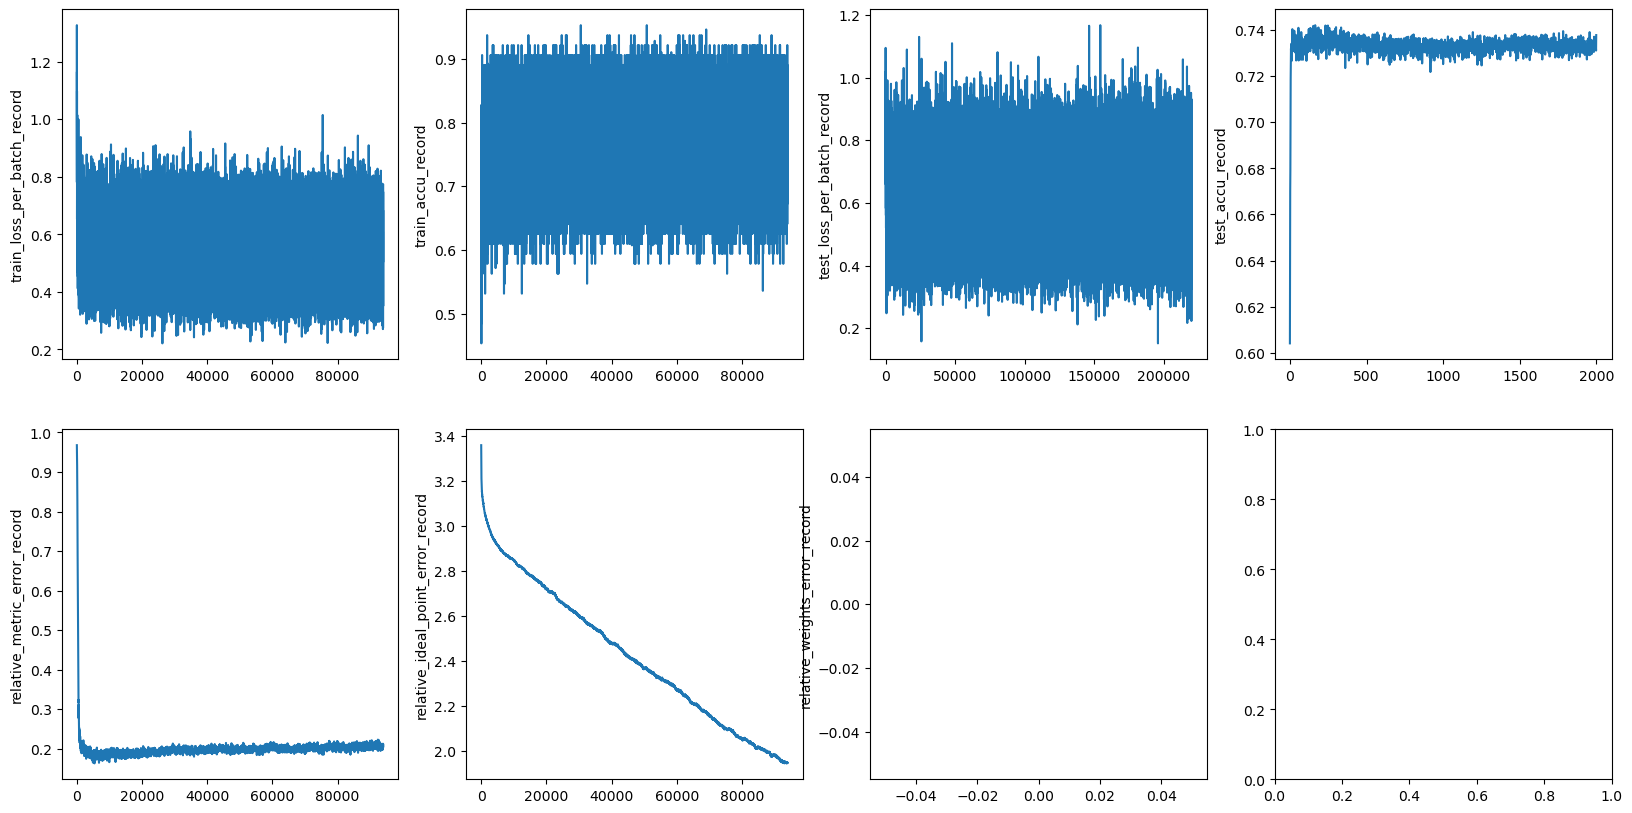

In [30]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

# Just for verification

In [ ]:
# true prediction (just for verification) original just one subgroup version
delta_s = []
pred_ys = []
for obs in S:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (Xdata[:,x_i]-U[:,user_id]).T @ M @ (Xdata[:,x_i]-U[:,user_id]) - (Xdata[:,x_j]-U[:,user_id]).T @ M @ (Xdata[:,x_j]-U[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == Y_noiseless), "doesn't match!"

In [21]:
# true prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == true_y_noiseless)